<a href="https://colab.research.google.com/github/Galtan-dev/Learning/blob/master/svc_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import itertools

# sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

# Import

In [7]:
# Data and columns
data = pd.read_html("https://web.vscht.cz/~steinbaj/python_ml/fish.htm")[0]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [8]:
# Information on the numerical data
data.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


In [9]:
# Information on the features
data.groupby("Species")["Species"].count()

Species
Bream        35
Parkki       11
Perch        56
Pike         17
Roach        20
Smelt        14
Whitefish     6
Name: Species, dtype: int64

# Preprocessing

In [10]:
# Columns for the features and output
columns = list(data.columns)
y_col = columns[0]
x_cols = columns[1:]
# Scaler
scale = MinMaxScaler()
# Scaling features and defining the arrays with features and output
x_scaled = scale.fit_transform(data[x_cols].to_numpy())
y = data[y_col].to_numpy()
# Split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.4,
                                                    random_state=5, stratify=y)

# Fitting an SVM classifier

In [11]:
# SVM classifier
clf = svm.SVC()
# Training
clf.fit(x_train, y_train)
# Prediction for validation
y_pred = clf.predict(x_test)
accuracy_score(y_pred, y_test)

0.78125

# Comparison between different kernel transformations

In [12]:
# Kernels and regularization params
kernels = ["linear", "poly", "rbf", "sigmoid"]  # rbf radio based function
# regularizační parametry
C_params = np.array([0.1, 1, 5, 10, 50, 100, 500])
# gama určije jak moc se má funkce kenelovská omotat kolem dat, zůžení hranice, nízké gama vede k regularizaci, nízké k přetrénování
gammas = [0.1, 1, 10, 100, 1000, 10000]
# Table for saving results
df_accuracy = pd.DataFrame({"kernel":[], "C":[], "gamma":[], "fit_acc": [],
                            "validation_acc":[]})
# Checking accuracy of different combinations
for kernel, C, gamma in itertools.product(kernels, C_params, gammas):
  # vytvořím klasifikátor
    clf = svm.SVC(kernel=kernel, C=C, gamma=gamma)
    # nafituju data
    clf.fit(x_train, y_train)
    # uložim si perdikce
    y_pred_train = clf.predict(x_train)
    y_pred_test = clf.predict(x_test)
    # do tabulky uložim výsledky pomocí lokátoru
    df_accuracy.loc[df_accuracy.shape[0]] = \
     [kernel, C, gamma, accuracy_score(y_pred_train, y_train),
      accuracy_score(y_pred_test, y_test)]
print("Done!")
# při spištení to řve že tam některé věci nejsou ale asi v pohodě

Done!


In [13]:
# Finding the best score based on the accuracy
best_params = df_accuracy[df_accuracy.validation_acc ==
                          max(df_accuracy.validation_acc)].iloc[0]
best_params

kernel                poly
C                      0.1
gamma               1000.0
fit_acc                1.0
validation_acc    0.984375
Name: 46, dtype: object

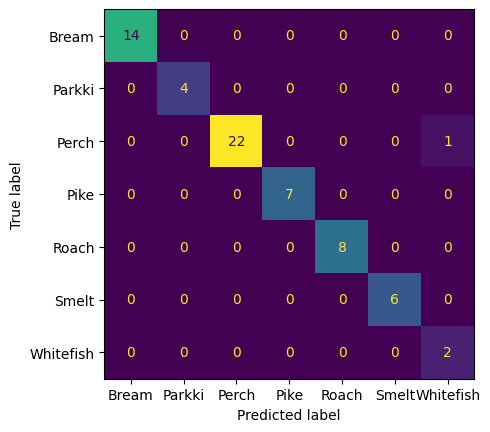

In [14]:
# Performance of the classifier with the best parameters
clf = svm.SVC(kernel=best_params["kernel"], C=best_params["C"],
              gamma=best_params["gamma"])
# nafitujem na trenovacich datech
clf.fit(x_train, y_train)
# spočitame si predikci testovacích dat
y_pred = clf.predict(x_test)
# udělame si matici záměn
cm = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred),
                            display_labels = clf.classes_)
cm.plot(colorbar=False)

# Overfitting a classifier

Vliv velikosti **gamma** parametru na přesnost fitu a přesnost validace.
Příliš nízké hodnoty gamma způsobí ztrátu "tvaru" hyperplane, takže chování klasifikátoru se bude blížit lineárnímu.
Příliš vysoké hodnoty gamma zvyšují vliv okolních bodů na tvar hyperplane, což může vést k overfittingu.

In [15]:
gammas = [0.1, 1, 10, 100, 1000, 10000]
for gamma in gammas:
  # udělame si undentifikator kam uložime gamu a nastavíme kernel
  clf = svm.SVC(kernel="rbf", gamma=gamma)
  # nafitujem
  clf.fit(x_train, y_train)
  y_pred_train = clf.predict(x_train)
  y_pred_test = clf.predict(x_test)
  print(f"Kernel: rbf. Gamma parameter: {gamma:.0e}.")
  print(f"\t - Training Accuracy: {accuracy_score(y_pred_train, y_train):.2%}."
    f"Validation accuracy: {accuracy_score(y_pred_test, y_test):.2%}.")

Kernel: rbf. Gamma parameter: 1e-01.
	 - Training Accuracy: 46.32%.Validation accuracy: 48.44%.
Kernel: rbf. Gamma parameter: 1e+00.
	 - Training Accuracy: 71.58%.Validation accuracy: 76.56%.
Kernel: rbf. Gamma parameter: 1e+01.
	 - Training Accuracy: 81.05%.Validation accuracy: 81.25%.
Kernel: rbf. Gamma parameter: 1e+02.
	 - Training Accuracy: 84.21%.Validation accuracy: 78.12%.
Kernel: rbf. Gamma parameter: 1e+03.
	 - Training Accuracy: 97.89%.Validation accuracy: 46.88%.
Kernel: rbf. Gamma parameter: 1e+04.
	 - Training Accuracy: 100.00%.Validation accuracy: 37.50%.
